In [14]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # for data visualization
import seaborn as sns # for statistical data visualization
%matplotlib inline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, make_scorer, precision_score, roc_curve, auc,roc_auc_score
import itertools
from sklearn.ensemble import GradientBoostingClassifier
from imblearn.over_sampling import SMOTE
from scipy.stats import randint, uniform

In [15]:
#read dataset
data='/content/CSRF_dataset.csv'
df= pd.read_csv(data)

In [16]:
X = df.drop(['flag'], axis=1)
y = df['flag']

In [17]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [18]:
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

In [19]:
print("Train set counts after SMOTE:")
print(y_train_res.value_counts())

Train set counts after SMOTE:
flag
0    3967
1    3967
Name: count, dtype: int64


In [20]:
y_train_pred, y_test_pred = None, None
def evaluate_model (model) :
    global y_train_pred, y_test_pred
    y_train_pred = model.predict(X_train_res)
    y_test_pred = model.predict(X_test)

In [21]:
def show_confusion_matrix ():
    cm_train = confusion_matrix(y_train_res, y_train_pred)
    cm_test = confusion_matrix(y_test, y_test_pred)

    # Plot confusion matrix
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(cm_train, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix - Training')
    plt.colorbar()
    tick_marks = np.arange(len(np.unique(y_train)))
    plt.xticks(tick_marks, np.unique(y_train))
    plt.yticks(tick_marks, np.unique(y_train))
    fmt = 'd'
    thresh = cm_train.max() / 2.
    for i, j in itertools.product(range(cm_train.shape[0]), range(cm_train.shape[1])):
        plt.text(j, i, format(cm_train[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm_train[i, j] > thresh else "black")
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

    plt.subplot(1, 2, 2)
    plt.imshow(cm_test, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix - Testing')
    plt.colorbar()
    tick_marks = np.arange(len(np.unique(y_test)))
    plt.xticks(tick_marks, np.unique(y_test))
    plt.yticks(tick_marks, np.unique(y_test))
    fmt = 'd'
    thresh = cm_test.max() / 2.
    for i, j in itertools.product(range(cm_test.shape[0]), range(cm_test.shape[1])):
        plt.text(j, i, format(cm_test[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm_test[i, j] > thresh else "black")
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

    plt.tight_layout()
    plt.show()

In [31]:
from sklearn.metrics import classification_report, roc_auc_score

def get_classification_report():
    # Calculate predicted probabilities for training and testing sets
    y_train_pred_proba = random_search.best_estimator_.predict_proba(X_train_res)[:, 1]
    y_test_pred_proba = random_search.best_estimator_.predict_proba(X_test)[:, 1]

    # Convert predicted probabilities to binary predictions for classification report
    y_train_pred = (y_train_pred_proba >= 0.5).astype(int)
    y_test_pred = (y_test_pred_proba >= 0.5).astype(int)

    # Calculate ROC AUC score for training and testing
    roc_auc_train = roc_auc_score(y_train_res, y_train_pred_proba)
    roc_auc_test = roc_auc_score(y_test, y_test_pred_proba)

    cr_train = classification_report(y_train_res, y_train_pred, output_dict=True)
    cr_test = classification_report(y_test, y_test_pred, output_dict=True)

    metrics = {
        'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-score', 'ROC AUC'],
        'Train': [cr_train['accuracy'], cr_train['1']['precision'], cr_train['1']['recall'], cr_train['1']['f1-score'], roc_auc_train],
        'Test': [cr_test['accuracy'], cr_test['1']['precision'], cr_test['1']['recall'], cr_test['1']['f1-score'], roc_auc_test]
    }
    metrics_df = pd.DataFrame(metrics)
    return metrics_df

In [23]:
def show_roc_curve(model):
    # Plot ROC curve and calculate AUC
    y_train_proba = model.predict_proba(X_train_res)[:,1]
    y_test_proba = model.predict_proba(X_test)[:,1]

    fpr_train, tpr_train, _ = roc_curve(y_train_res, y_train_proba)
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_proba)

    auc_train = auc(fpr_train, tpr_train)
    auc_test = auc(fpr_test, tpr_test)

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr_train, tpr_train, label=f'Train AUC = {auc_train:.2f}')
    plt.plot(fpr_test, tpr_test, label=f'Test AUC = {auc_test:.2f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

In [24]:
roc_auc_scorer = make_scorer(roc_auc_score, average='weighted', multi_class='ovr')

---
# Gradient Boosted Decision

### Most important hyperparameters that we have to deal with :
#### 1. n_estimators: Number of trees in the ensemble. Higher values may lead to overfitting
#### 2. learning_rate: Controls the contribution of each tree; lower values improve generalization but require more trees
#### 3. max_depth: Maximum depth of trees; controls overfitting. Higher values capture complex patterns but may overfit.
#### 4. min_samples_leaf: Minimum allowed number of samples in each leaf node (Lower values => Higher overfitting risk)
#### 5. min_samples_split: Minimum samples required to split a node; higher values prevent learning overly specific patterns.
#### 6. subsample: Fraction of samples used for fitting each tree; values <1 reduce variance, improving robustness
#### 7. max_features: Number of features considered for splits; sqrt or log2 often work well. Controls model complexity

In [27]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
import numpy as np

# Define parameters for random search
parameters = {
    'n_estimators': [100, 150, 180, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_samples_split': [4, 9, 12, 20],
    'min_samples_leaf': [2, 5, 10, 15, 18],
    'subsample': [0.5, 0.8, 0.9, 1.0],
    'max_features': [None, 'sqrt', 'log2', 0.5]
}

# Initialize the Gradient Boosting Classifier
gbdt = GradientBoostingClassifier()

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    gbdt,
    parameters,
    n_iter=50,  # Number of random combinations to try
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    random_state=42
)

# Fit the model
random_search.fit(X_train, y_train)

# Best parameters found
print(f'Best parameters: {random_search.best_params_}')

# Calculate ROC AUC on training set
y_pred_train = random_search.best_estimator_.predict_proba(X_train)[:, 1]
roc_auc_train = roc_auc_score(y_train, y_pred_train)
print("ROC AUC score on training set: ", roc_auc_train)

# Calculate ROC AUC on testing set
y_pred_test = random_search.best_estimator_.predict_proba(X_test)[:, 1]
roc_auc_test = roc_auc_score(y_test, y_pred_test)
print("ROC AUC score on testing set: ", roc_auc_test)


Best parameters: {'subsample': 1.0, 'n_estimators': 150, 'min_samples_split': 9, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 5, 'learning_rate': 0.2}
ROC AUC score on training set:  0.9789117505516771
ROC AUC score on testing set:  0.9379670089578327


In [28]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
import numpy as np

# Define parameters for random search
parameters = {
    'n_estimators': [100, 150, 180, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_samples_split': [4, 9, 12, 20],
    'min_samples_leaf': [2, 5, 10, 15, 18],
    'subsample': [0.5, 0.8, 0.9, 1.0],
    'max_features': [None, 'sqrt', 'log2', 0.5]
}

# Initialize the Gradient Boosting Classifier
gbdt = GradientBoostingClassifier()

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    gbdt,
    parameters,
    n_iter=100,  # Number of random combinations to try
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    random_state=42
)

# Fit the model
random_search.fit(X_train, y_train)

# Best parameters found
print(f'Best parameters: {random_search.best_params_}')

# Calculate ROC AUC on training set
y_pred_train = random_search.best_estimator_.predict_proba(X_train)[:, 1]
roc_auc_train = roc_auc_score(y_train, y_pred_train)
print("ROC AUC score on training set: ", roc_auc_train)

# Calculate ROC AUC on testing set
y_pred_test = random_search.best_estimator_.predict_proba(X_test)[:, 1]
roc_auc_test = roc_auc_score(y_test, y_pred_test)
print("ROC AUC score on testing set: ", roc_auc_test)


Best parameters: {'subsample': 1.0, 'n_estimators': 150, 'min_samples_split': 9, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 5, 'learning_rate': 0.2}
ROC AUC score on training set:  0.9788814201116429
ROC AUC score on testing set:  0.9413152720122351


In [45]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
import numpy as np

# Define parameters for random search
parameters = {
    'n_estimators': [100, 150, 180, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_samples_split': [4, 9, 12, 20],
    'min_samples_leaf': [2, 5, 10, 15, 18],
    'subsample': [0.5, 0.8, 0.9, 1.0],
    'max_features': [None, 'sqrt', 'log2', 0.5]
}

# Initialize the Gradient Boosting Classifier
gbdt = GradientBoostingClassifier()

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    gbdt,
    parameters,
    n_iter=1000,  # Number of random combinations to try
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    random_state=42
)

# Fit the model
random_search.fit(X_train, y_train)

# Best parameters found
print(f'Best parameters: {random_search.best_params_}')

# Calculate ROC AUC on training set
y_pred_train = random_search.best_estimator_.predict_proba(X_train)[:, 1]
roc_auc_train = roc_auc_score(y_train, y_pred_train)
print("ROC AUC score on training set: ", roc_auc_train)

# Calculate ROC AUC on testing set
y_pred_test = random_search.best_estimator_.predict_proba(X_test)[:, 1]
roc_auc_test = roc_auc_score(y_test, y_pred_test)
print("ROC AUC score on testing set: ", roc_auc_test)


Best parameters: {'subsample': 0.9, 'n_estimators': 200, 'min_samples_split': 4, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'max_depth': 5, 'learning_rate': 0.1}
ROC AUC score on training set:  0.9660903995395165
ROC AUC score on testing set:  0.9401327288616997


In [46]:
gbdt_model = random_search.best_estimator_
evaluate_model(gbdt_model)

In [47]:
get_classification_report()

,Metric,Train,Test
0,Accuracy,0.669650,0.921968
1,Precision,0.955345,0.802632
2,Recall,0.355936,0.663043
3,F1-score,0.518641,0.726190
4,ROC AUC,0.929814,0.940133


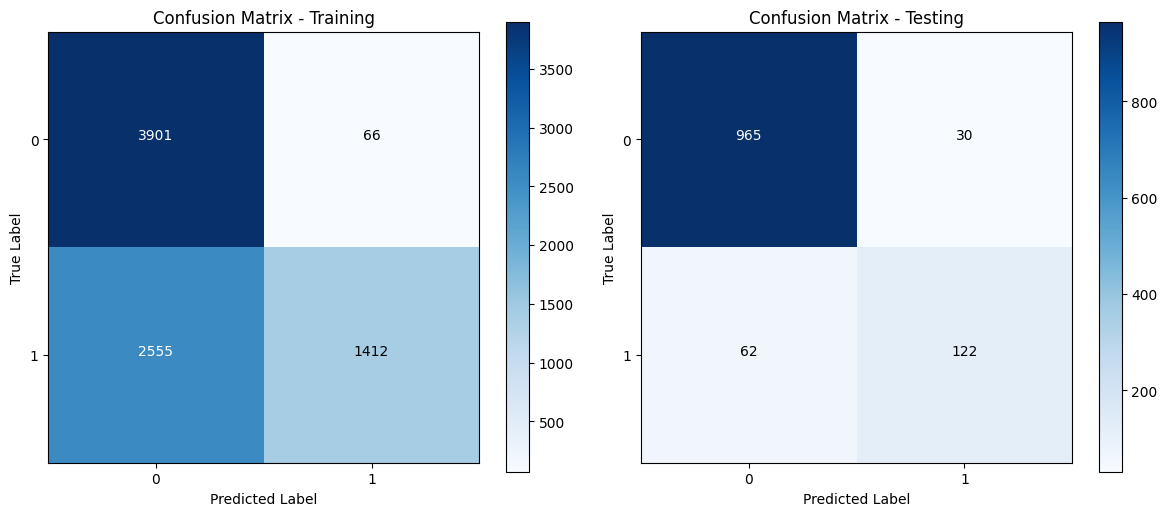

In [48]:
show_confusion_matrix()

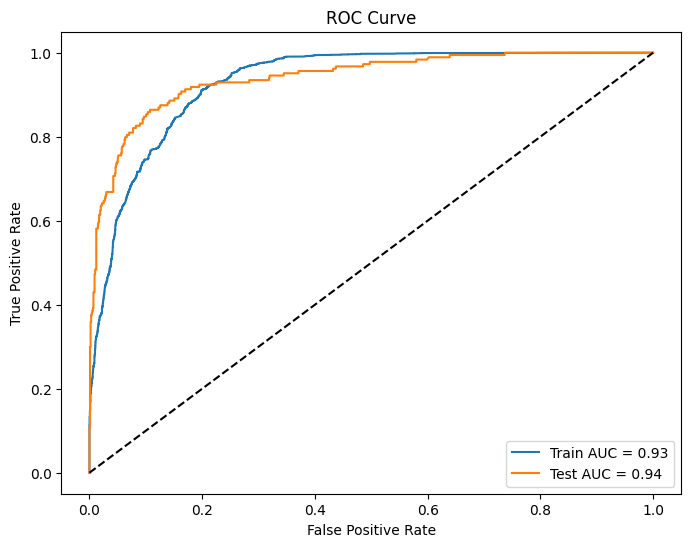

In [49]:
show_roc_curve(gbdt_model)

In [50]:
import pickle
path = "/content/sample_data/Model/gbdt_model.pkl"

# Save the model to a file
with open(path, 'wb') as file:
    pickle.dump(gbdt_model, file)

In [51]:
import pickle

record = "3,0,0,0,150,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0"
input_data = pd.DataFrame([list(map(float, record.split(',')))])
input_data.columns = ['reqId', 'numOfParams', 'numOfIds', 'reqLen', 'createInPath',
       'createInParams', 'addInPath', 'addInParams', 'setInPath',
       'setInParams', 'deleteInPath', 'deleteInParams', 'updateInPath',
       'updateInParams', 'removeInPath', 'removeInParams', 'friendInPath',
       'friendInParams', 'settingInPath', 'settingInParams', 'passwordInPath',
       'passwordInParams', 'tokenInPath', 'tokenInParams', 'changeInPath',
       'changeInParams', 'actionInPath', 'actionInParams', 'payInPath',
       'payInParams', 'loginInPath', 'loginInParams', 'logoutInPath',
       'logoutInParams', 'postInPath', 'postInParams', 'commentInPath',
       'commentInParams', 'followInPath', 'followInParams', 'subscribeInPath',
       'subscribeInParams', 'signInPath', 'signInParams', 'viewInPath',
       'viewInParams', 'isPUT', 'isDELETE', 'isPOST', 'isGET', 'isOPTIONS']
# Load the model from the file
with open(path, 'rb') as file:
    loaded_model = pickle.load(file)

# Now you can use the loaded model for predictions
predictions = loaded_model.predict(input_data)
print("Predictions: ", predictions)


Predictions:  [0]
